## *Text as data for idiosyncratic price changes*
#### In macroeconomics, the rate at which individual firms adjust their prices is important for monetary policy, but is unobservable in  aggregate inflation statistics. Specifically, if the probability of firm $i$ changing goods to their optimal level $x$  is represented by $\lambda_{i}$, where $\lambda \in [0, 1]$, the firm's price level at time $t$ is given by $ p_{it} = (1-\lambda_{i})p_{it-1} + \lambda_{i}x_{it}$.  By averaging across firm-level price changes, the idiosyncratic component of firm-level price setting theory $(\lambda)$ is lost in aggregation $(e.g., \space \pi_t = \frac{1}{N}\sum_{i=0}^N p_{it}-p_{it-1}).$
#### Firm level price data has been made available by the Bureau of Labor Statistics (BLS) starting in the late 1970's. However, data from newspapers that advertise firm's price changes (i.e., sales) are publicly available from the late 1800s. In macroeconomic theory, firm sales (temporary price changes) have implications for both monetary policy and inflation. The purpose of this notebook is to make use of a novel dataset, consisting of the text of advertisements appearing in the New York Times from 1850-2010. Each record has a binary variable indicating if the advertisement was for a sale (sale = 1) or not (sale = 0). We aim to answer two questions:

* *Question 1: Can the text from advertisements be used to predict whether a price change occurred (i.e., a sale)?*
* *Question 2: Can the text from advertisements be used to easily categorize a product? This is needed since data from the BLS is based on different industries/categories, and for sale data to be useful, product category would be necessary*



In [1]:
#Import basic libraries

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
import seaborn as sns
pd.options.mode.chained_assignment = None

### Question 1:  Can the text from advertisements be used to predict whether a price change occurred?

#### *Data Exploration and Logistic Regression*

In [2]:
# Import Data
# Data consists of three columns in a csv document: 1) Year of Advertisment, 2) Text from Advertisment, 3) Binary Variable for if ad was a sale or not (0 = no sale, 1 = sale)
#'Sale' defined as the advertisment for a reduction in price for a given product
# There are approximately 3000 records in the dataset, however, only a random subsample can be made publically available
wd = os.getcwd()
data_path = os.path.join(wd,"..","data/nytimes_sales_sample.csv")
nytimes_data = pd.read_csv(data_path, engine='python')
# Randomize the records
nytimes_data = nytimes_data.sample(frac=1)

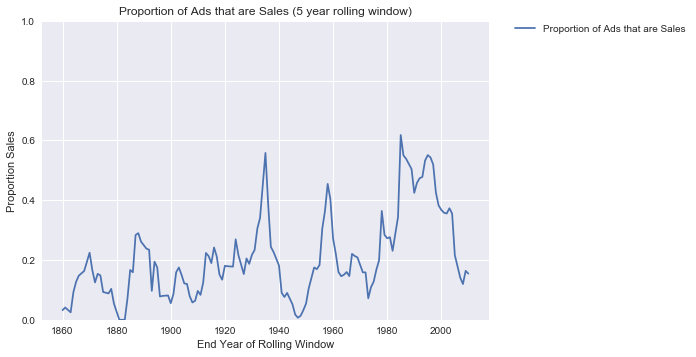

In [3]:
# Let's start by looking at the proportion of ads in the data that are sales, by year
# Given that there may not be a consistent number of ads per year, looking at a 5-year rolling average will be useful

nytimes_data_sales = pd.crosstab(nytimes_data.Year, nytimes_data.Sale)
del nytimes_data_sales.index.name
nytimes_data_sales.columns = ['Num_NonSale', 'Num_Sale']
for i in range(0,len(nytimes_data_sales)-4):
    data = nytimes_data_sales.iloc[0+i:5+i,:]
    data['Total'] = data['Num_NonSale'] + data['Num_Sale']
    total = data.Total.sum()
    total_sales = data.Num_Sale.sum()
    proportion = total_sales / total
    if i == len(nytimes_data_sales)-4:
        end_year = data.index[3]
    else:
        end_year = data.index[4]
    rolling_window_proportions = pd.DataFrame({'total': [total], 'sales': [total_sales], 'proportion_sales': [proportion], 'end_year': [end_year]})
    if i == 0:
        proportions_combined = rolling_window_proportions
    else:
        proportions_combined = pd.concat([proportions_combined, rolling_window_proportions])
        
#Plot proportion of sales ads over time to see if there is a consistent temporal trend
plt.plot(proportions_combined.end_year, proportions_combined.proportion_sales, label='Proportion of Ads that are Sales')
plt.ylim([0.0, 1.0])
plt.ylabel('Proportion Sales')
plt.xlabel('End Year of Rolling Window')
plt.title('Proportion of Ads that are Sales (5 year rolling window)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [4]:
# Preliminary text data cleaning - make all text data lowercase and remove special characters
nytimes_data['Text'] = nytimes_data['Text'].str.lower()
nytimes_data['Text'] = nytimes_data['Text'].str.replace('[^a-zA-Z\s]','')

In [5]:
# As a first pass, it will be useful to see if terms that would be expected to represent a sale ad (e.g., 'sale', 'save', 'reduced price') are predictive
# Apply a logistic regression and compare coefficients
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2

# Vectorize the text (i.e., document/term matrix) and remove english stop words (e.g., "and", "the", etc.)
# For now, use single words (i.e., not word combinations)
vectorizer = CountVectorizer(binary=True, stop_words='english', ngram_range=(1, 1))
X = vectorizer.fit_transform(nytimes_data['Text'])

#Define target, model and measure of significance (using chi-square p-value)
sale = nytimes_data['Sale']
prelim_model = linear_model.LogisticRegression()
results = prelim_model.fit(X, sale)
score, p_values = chi2(X, sale)
#Get names of each term, and append coefficient and p-values. Sort data in order to see the 10 words with the largest coefficients
results_df_names = pd.DataFrame(np.transpose(vectorizer.get_feature_names()), columns=['Word'])
results_df_coef = pd.DataFrame(np.transpose(results.coef_[0]), columns=['Coef'], dtype=float)
pvalue_array_df = pd.DataFrame(np.transpose(np.asarray(p_values, dtype=np.float32)), columns=['p-value'], dtype=float)
results_dataframe = pd.concat([results_df_names, results_df_coef, pvalue_array_df], axis=1).sort_values(by=['Coef'], ascending=False)
print(results_dataframe.head(n=10))

               Word      Coef       p-value
23454          sale  2.565036  0.000000e+00
5149      clearance  1.906437  0.000000e+00
23668          save  1.856015  9.809089e-45
22157       reduced  1.845659  4.116385e-36
22294     regularly  1.154202  1.395056e-29
13777  installments  1.095143  5.517051e-04
22251           reg  1.027932  2.612227e-34
29216           val  0.950817  1.256345e-04
23477         sales  0.913314  7.164620e-19
23677       savings  0.906463  3.491767e-27


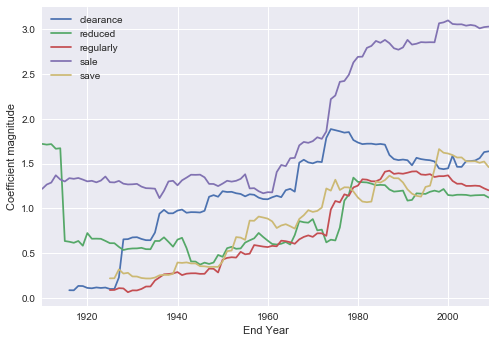

In [6]:
# The expected terms are represented. However, this is over the full time period. It would be interesting to see how the
# magnitude of the coefficients change over time. From economic history, we know that sales have increased over time
# so the coefficients of each of these predictive terms may also increase over time
year_range = 100
for i in range(0,year_range):
    temp_df = nytimes_data[(nytimes_data.Year >= 1860+i) & (nytimes_data.Year <= 1910+i)]
    sale = temp_df['Sale']
    X = vectorizer.fit_transform(temp_df['Text'])
    results = prelim_model.fit(X, sale)
    score, p_values = chi2(X, sale)
    results_df_names = pd.DataFrame(np.transpose(np.asarray(vectorizer.get_feature_names())),columns=['Word']) 
    results_df_coef = pd.DataFrame(np.transpose(results.coef_[0]), columns=['Coef'], dtype=float)
    pvalue_array_df = pd.DataFrame(np.transpose(np.asarray(p_values, dtype=np.float32)), columns=['p_value'], dtype=float)
    results_dataframe.i = pd.concat([results_df_names, results_df_coef, pvalue_array_df], axis=1)
    results_dataframe.i = results_dataframe.i[(results_dataframe.i.p_value <= 0.05)]
    results_dataframe.i = results_dataframe.i[(results_dataframe.i.Word == 'sale') | (results_dataframe.i.Word == 'clearance') | (results_dataframe.i.Word == 'regularly')| (results_dataframe.i.Word == 'save') | (results_dataframe.i.Word == 'reduced')]
    results_dataframe.i['End Year'] = 1910+i
    if i == 0:
        results_dataframe_combined = results_dataframe.i
    else:
        results_dataframe_combined = pd.concat([results_dataframe_combined, results_dataframe.i])
        
# Plot
fig, ax = plt.subplots()
plt.ylabel('Coefficient magnitude')

for index, group in results_dataframe_combined.groupby('Word'):
    group.plot(x='End Year', y='Coef', label=index, ax=ax)

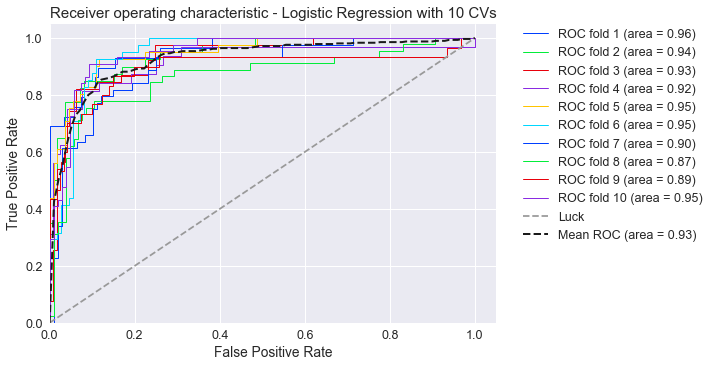

In [7]:
# Let's run the logistic regression with cross validation and see how it performs
# It is important to evaluate the variance of the ROC when the dataset gets split into subsets
# This will help to demonstrate how the logistic regression output is affected by changes in the training data
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

kf = KFold(n_splits=10)
sns.set(style="darkgrid", color_codes=True, font_scale=1.25, palette='bright')

# Run classifier with cross-validation and plot ROC curves
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

i=0
for train_index, test_index in kf.split(X):
    i += 1
    probas_ = prelim_model.fit(X[train_index].todense(), sale.iloc[train_index]).predict_proba(X[test_index].todense())
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(sale.iloc[test_index], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= 10
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Logistic Regression with 10 CVs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### *Additional Machine Learning Methods (Linear and Non-linear)*

In [8]:
# The ROC curves above look promising! However, we should evaluate more complex linear machine learning methods in order
# to understand the predictive capabilities of the text. The code below explores regularized techniques including
# regularized logistic regression (L1 and L2 loss function), ridge classifier, and linear SVC.
# Each kfold split (n=5) is evaluated on accuracy (i.e., how many records are correctly identified), precision
# (i.e., items labeled as 'sale' that are truely a 'sale'), recall (i.e., the percentage of true sales that were identified),
# and F-score (the harmonic mean of precision and recall)

from sklearn import svm
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Can control regularization with these measures (smaller "C" => more regularization) 
C=0.5
alpha = 1/C
classifiers = {'L1 logistic': LogisticRegression(C=C, penalty='l1'),
               'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2'),
               'Linear SVC': svm.SVC(kernel='linear', C=C, probability=True,
                                 random_state=0),
               'Ridge': RidgeClassifier(alpha=alpha)}

kf = KFold(n_splits=5)
target = sale
term_names = vectorizer.get_feature_names()
term_names = pd.DataFrame(term_names, columns=['Term']) 


i=0
for train_index, test_index in kf.split(X):
    i += 1
    print("CV #%d Performance" % (i))
    print("------------------------------------------------------")
    for index, (name, classifier) in enumerate(classifiers.items()):
        results = classifier.fit(X[train_index].todense(), target.iloc[train_index])
        Y_pred = classifier.predict(X[test_index].todense())
    
        results_coef_array = np.transpose(results.coef_)
        results_df_coef = pd.DataFrame(results_coef_array, columns=['Coef'])
        results_df_coef = pd.concat([term_names, results_df_coef], axis = 1)
        results_df_coef = results_df_coef.sort_values(by='Coef', ascending=False)
        results_df_coef = results_df_coef[results_df_coef.Coef > 0]
        
        print("%s:" % name)
        print("  Predicted Sales in Test Set: %d" % Y_pred.sum())
        print("  Actual Sales in Test Set: %d" % target.iloc[test_index].sum())
        print(' ')
        print("  Accuracy: %1.3f" % accuracy_score(target.iloc[test_index], Y_pred))
        print("  Precision: %1.3f" % precision_score(target.iloc[test_index], Y_pred))
        print("  Recall: %1.3f" % recall_score(target.iloc[test_index], Y_pred))
        print("  F1: %1.3f\n" % f1_score(target.iloc[test_index], Y_pred))
        print(' ')
        print("Top 5 most predictive words")
        print(results_df_coef.head(n=5))
        print(' ')

CV #1 Performance
------------------------------------------------------
L1 logistic:
  Predicted Sales in Test Set: 60
  Actual Sales in Test Set: 69
 
  Accuracy: 0.885
  Precision: 0.783
  Recall: 0.681
  F1: 0.729

 
Top 5 most predictive words
            Term      Coef
3467   clearance  2.756319
15436       sale  2.741874
14649  regularly  2.027761
13905    printer  1.993039
15584       save  1.133891
 
L2 logistic (OvR):
  Predicted Sales in Test Set: 59
  Actual Sales in Test Set: 69
 
  Accuracy: 0.895
  Precision: 0.814
  Recall: 0.696
  F1: 0.750

 
Top 5 most predictive words
            Term      Coef
15436       sale  2.531714
3467   clearance  1.240507
15584       save  1.056118
14649  regularly  0.886215
11121       mens  0.833817
 
Linear SVC:
  Predicted Sales in Test Set: 65
  Actual Sales in Test Set: 69
 
  Accuracy: 0.888
  Precision: 0.769
  Recall: 0.725
  F1: 0.746

 
Top 5 most predictive words
               Term      Coef
15436          sale  0.940940
3467  

In [15]:
# The above linear models performed well (most recall statistics were around 70%). However, it is useful to 
# evaluate non-linear methods. Below we implement a Random Forest, with 50 trees. We have 20,500 features (words)
# in the dataset, therefore, max features has been set to 3,000 in order to provide randomness into the process of feature selection.

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split


rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_features=3000)

##Statistics of the model
X_test, X_train, Y_test, Y_train = train_test_split(X, sale, test_size=0.5, random_state=123)
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print("\tAccuracy: %1.3f" % accuracy_score(Y_test, Y_pred))
print("\tPrecision: %1.3f" % precision_score(Y_test, Y_pred))
print("\tRecall: %1.3f" % recall_score(Y_test, Y_pred))
print("\tF1: %1.3f\n" % f1_score(Y_test, Y_pred))

	Accuracy: 0.872
	Precision: 0.763
	Recall: 0.736
	F1: 0.749



#### *Based on the findings above, text from advertisements could be a useful data source for identifying the proportion of temporary price changes within an economy. Given a large dataset of newspaper advertisements the algorithms trained above could identify approximately 75% of temporary price changes. The most predictive words stayed consistent over a long time period (i.e., 100 years), which will be useful for constructing time series. *

### Question 2: Can the text from advertisements be used to easily categorize a product? 

In [10]:
# In order to categorize groups of products using text data, we will more thoroughly clean the text data,
# implement Lancaster stemming, and use Non-negative matrix factorization (NMF) to categorize.
# NMF is a form of dimensionality reduction. This process essentially groups the terms of the corpus into ‘topics’. For
# example, a topic emerges below after factorization with the following terms, creating a group of terms specific to wine: ‘chardonnay’, ‘sauvignon’, ‘cabernet’, and ‘reserve’.
# We will reduce a standard  document-term matrix into document-topic matrix with 150 topics.
# Each advertisement could then be assigned to a single topic based on the topic with the highest weight for that given advertisement.
# If the dimensionality reduction creates groups that represent product type, the text from advertisements could also be used
# to create product-specific time series

# Tokenize words, remove stopwords, and stem the text
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
stopwords = stopwords.words('english')

tokens = [word_tokenize(advertisement) for advertisement in nytimes_data['Text']]

def stem_tokens(tokens):
    stemmed_token = np.empty((len(tokens),0)).tolist()
    for ad_num in tokens:
        n = tokens.index(ad_num)
        for word in ad_num:
            if word not in stopwords:
                stem = st.stem(word)
                stemmed_token[n].append(stem)
    return stemmed_token
        
stemmed = stem_tokens(tokens)

In [11]:
##Manipulate stemmed text to be string instead of list (needed for count vectorizer)
def make_string(text):
    final_text = []
    for ad_num in text:
        for word in ad_num:
            n = ad_num.index(word)
            if n == 0:
                string = ad_num[n]
            else:
                string = string + " " + ad_num[n]
        final_text.append(string)
    return final_text

final_text = make_string(stemmed)

In [12]:
##Count Vectorizer Matrix
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix, vstack
import scipy

vectorizer = CountVectorizer(binary=False, ngram_range=(1, 1))
text_matrix = vectorizer.fit_transform(final_text)
feature_names = vectorizer.get_feature_names()

##Remove if word is in less than 10 Ads (to get rid of anomalies)
word_counts = scipy.sparse.coo_matrix.sum(text_matrix, axis=0)
text_matrix = np.transpose(vstack([text_matrix, word_counts]))
text_matrix = pd.DataFrame(text_matrix.todense(), index = feature_names)
last_col = text_matrix.shape[1] - 1
text_matrix = text_matrix[text_matrix[last_col] > 10]
del text_matrix[last_col]
text_matrix = text_matrix.transpose()
feature_names = text_matrix.columns.values
text_matrix = text_matrix.as_matrix()

In [13]:
##Non-negative matrix factorization
n_topics = 150

from sklearn.decomposition import NMF
model = NMF(init="nndsvd", n_components=n_topics, random_state=1)

W_matrix = model.fit_transform(text_matrix)
H_matrix = model.components_

In [14]:
##Prints topics and keywords
for topic_index in range(H_matrix.shape[0]):
    top_indices = np.argsort( H_matrix[topic_index,:] )[::-1][0:15]  ##show top 15 words associated with each topic
    term_ranking = [feature_names[i] for i in top_indices]
    print ("Topic %d: %s" % ( topic_index, ", ".join( term_ranking ) ))

Topic 0: lin, match, towel, sleev, etc, tan, napkin, hemstitch, sheet, damask, wind, cold, mat, lapel, also
Topic 1: xwool, plush, she, random, twist, xacryl, text, velvet, wool, instal, broadloom, sav, yard, yd, rich
Topic 2: xpak, bukhara, iv, xmeshkin, xardebl, xtabr, blu, xfin, xbeloud, gold, bukharaexpak, rust, xkum, xyalameh, xafsh
Topic 3: reedm, etc, stk, mil, pric, cond, air, pwr, auto, ht, cpe, us, vinyl, dbl, roof
Topic 4: select, every, orig, sportswear, ticket, form, cotton, purchas, design, cas, rug, dress, short, inf, pant
Topic 5: chardonnay, sauvignon, cabernet, septemb, reserv, vineyard, win, winery, blant, merlot, bordeaux, valley, est, de, vint
Topic 6: wor, week, last, worthc, cost, gold, cwor, per, retail, black, good, silk, poplin, bleach, alpac
Topic 7: company, stock, busy, meet, fund, canad, bank, march, year, corp, man, bond, mut, york, not
Topic 8: per, yard, inch, valu, silk, black, col, doz, good, wool, jacket, cap, clo, flannel, wom
Topic 9: pil, xwool, g